# Spaceship Titanic

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

**train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.**
* `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
* `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* `Destination` - The planet the passenger will be debarking to.
* `Age`- The age of the passenger.
* `VIP` - Whether the passenger has paid for special VIP service during the voyage.
* `RoomService, FoodCourt, ShoppingMall, Spa, VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* `Name` - The first and last names of the passenger.
* `Transported` - Whether the passenger was transported to another dimension. This is the `target`, the column you are trying to predict.
**test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.Your task is to predict the value of Transported for the passengers in this set.**
**sample_submission.csv - A submission file in the correct format.**
* `PassengerId` - Id for each passenger in the test set.
* `Transported` - The target. For each passenger, predict either True or False.

Metrics: `accuracy`


# Data overview

In [1]:
# Import all the tools
import warnings
from tqdm import tqdm_notebook
import seaborn as sns
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
# from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

train = pd.read_csv("/home/mikhail/data/Spaceship_Titanic/train.csv")
test = pd.read_csv("/home/mikhail/data/Spaceship_Titanic/test.csv")
sub = pd.read_csv('/home/mikhail/data/Spaceship_Titanic/sample_submission.csv')

# plots inside the notebook
%matplotlib inline
print('Train Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    train.shape, train.isna().sum().sum(), train.duplicated().sum()))
print('Test Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    test.shape, test.isna().sum().sum(), test.duplicated().sum()))
train_d = train.drop_duplicates()

if train.shape == train_d.shape:
    print('No duplicates')
else:
    print('Dropping Duplicates\nNew Train Shape: {}'.format(train_d.shape))

Train Shape: (8693, 14)
Missing Data: 2324
Duplicates: 0

Test Shape: (4277, 13)
Missing Data: 1117
Duplicates: 0

No duplicates


In [2]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [3]:
test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


This is a classificataion task with two classes: 1 or 0. Let's encode the target value

In [4]:
train['Transported'] = train['Transported'].astype(int)
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0


# EDA & FE

In [5]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported       int64
dtype: object

In [6]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

## Target

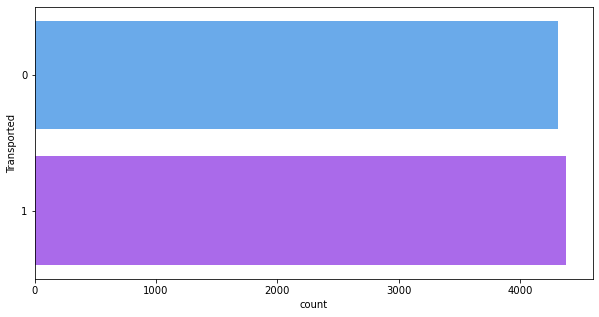

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(y=train['Transported'], palette='cool', orient='h')
plt.show()

In [9]:
y = train['Transported']
train.drop('Transported', axis=1, inplace=True)

## Age

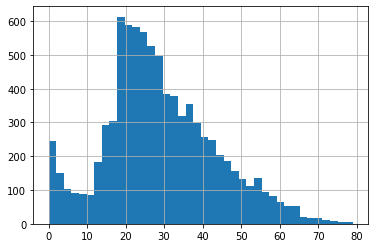

In [10]:
train.Age.hist(bins=40);

In [11]:
train.Age.describe()

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

Age looks good. From 0 to 79, truly

In [12]:
train.Age.isna().sum()

179

I guess this is not outliers:

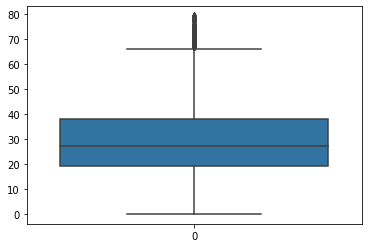

In [13]:
sns.boxplot(data=train.Age);

Let's add new columns which indicates `Ageismissing`

In [14]:
train['Ageismissing'] = train['Age'].isnull()
train['Age'].fillna(train['Age'].mean(), inplace=True)
train['Ageismissing'] = train['Ageismissing'].astype(int)

test['Ageismissing'] = test['Age'].isnull()
test['Age'].fillna(test['Age'].mean(), inplace=True)
test['Ageismissing'] = test['Ageismissing'].astype(int)

In [15]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Ageismissing
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0


In [16]:
train.Age.isna().sum()

0

In [17]:
train["Ageismissing"].unique()

array([0, 1])

In [18]:
train.loc[train["Ageismissing"]==1].head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Ageismissing
50,0052_01,Earth,False,G/6/S,TRAPPIST-1e,28.82793,False,4.0,0.0,2.0,4683.0,0.0,Elaney Hubbarton,1
64,0068_01,Mars,False,E/4/S,TRAPPIST-1e,28.82793,False,793.0,0.0,2.0,253.0,0.0,Cinst Binie,1


## RoomService

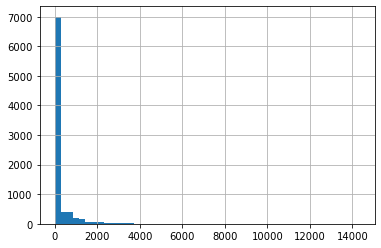

In [19]:
train['RoomService'].hist(bins=50);

Looks fine. Many people do not pay at all

In [20]:
train.RoomService.describe()

count     8512.000000
mean       224.687617
std        666.717663
min          0.000000
25%          0.000000
50%          0.000000
75%         47.000000
max      14327.000000
Name: RoomService, dtype: float64

In [21]:
train['RoomService'].isna().sum()

181

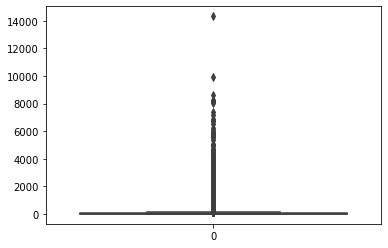

In [22]:
sns.boxplot(data=train['RoomService']);

I gues that nan is 0

Let's add column for poeple who paid for luxury amenities.

In [23]:
train['RoomService'].fillna(0, inplace=True)
test['RoomService'].fillna(0, inplace=True)

train['PaidRoomService'] = train['RoomService'] > 0
train['PaidRoomService'] = train['PaidRoomService'].astype(int)

test['PaidRoomService'] = test['RoomService'] > 0
test['PaidRoomService'] = test['PaidRoomService'].astype(int)

train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Ageismissing,PaidRoomService
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,0,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,1


In [24]:
train['RoomService'].isna().sum()

0

## FoodCourt

similar

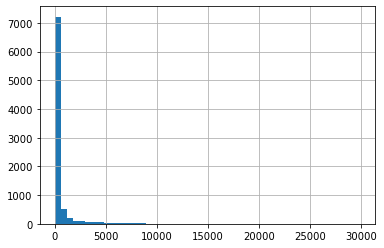

In [25]:
train['FoodCourt'].hist(bins=50);

Many zeros. Fill with 0

In [26]:
train.FoodCourt.describe()

count     8510.000000
mean       458.077203
std       1611.489240
min          0.000000
25%          0.000000
50%          0.000000
75%         76.000000
max      29813.000000
Name: FoodCourt, dtype: float64

In [27]:
train.FoodCourt.isna().sum()

183

In [28]:
train['FoodCourt'].fillna(0, inplace=True)
test['FoodCourt'].fillna(0, inplace=True)

train['PaidFoodCourt'] = train['FoodCourt'] > 0
train['PaidFoodCourt'] = train['PaidFoodCourt'].astype(int)

test['PaidFoodCourt'] = test['FoodCourt'] > 0
test['PaidFoodCourt'] = test['PaidFoodCourt'].astype(int)

train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Ageismissing,PaidRoomService,PaidFoodCourt
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,0,1,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,1,1


In [29]:
train.FoodCourt.isna().sum()

0

## ShoppingMall

In [30]:
train['ShoppingMall'].fillna(0, inplace=True)
test['ShoppingMall'].fillna(0, inplace=True)

train['PaidShoppingMall'] = train['ShoppingMall'] > 0
train['PaidShoppingMall'] = train['PaidShoppingMall'].astype(int)

test['PaidShoppingMall'] = test['ShoppingMall'] > 0
test['PaidShoppingMall'] = test['PaidShoppingMall'].astype(int)

train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Ageismissing,PaidRoomService,PaidFoodCourt,PaidShoppingMall
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,0,1,1,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,1,1,0


## Spa

In [31]:
train['Spa'].fillna(0, inplace=True)
test['Spa'].fillna(0, inplace=True)

train['PaidSpa'] = train['Spa'] > 0
train['PaidSpa'] = train['PaidSpa'].astype(int)

test['PaidSpa'] = test['Spa'] > 0
test['PaidSpa'] = test['PaidSpa'].astype(int)

train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Ageismissing,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,0,0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,0,1,1,1,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,1,1,0,1


## VRDeck

In [32]:
train['VRDeck'].fillna(0, inplace=True)
test['VRDeck'].fillna(0, inplace=True)

train['PaidVRDeck'] = train['VRDeck'] > 0
train['PaidVRDeck'] = train['PaidVRDeck'].astype(int)

test['PaidVRDeck'] = test['VRDeck'] > 0
test['PaidVRDeck'] = test['PaidVRDeck'].astype(int)

train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Ageismissing,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa,PaidVRDeck
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,0,0,0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,0,1,1,1,1,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,1,1,0,1,1


In [33]:
test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Ageismissing,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa,PaidVRDeck
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0,0,0,0,0,0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0,0,1,0,1,0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0,0,0,0,0,0


## One-hot checking

In [34]:
train.dtypes

PassengerId          object
HomePlanet           object
CryoSleep            object
Cabin                object
Destination          object
Age                 float64
VIP                  object
RoomService         float64
FoodCourt           float64
ShoppingMall        float64
Spa                 float64
VRDeck              float64
Name                 object
Ageismissing          int64
PaidRoomService       int64
PaidFoodCourt         int64
PaidShoppingMall      int64
PaidSpa               int64
PaidVRDeck            int64
dtype: object

In [35]:
train.PassengerId.value_counts()

0001_01    1
6136_01    1
6141_01    1
6139_06    1
6139_05    1
          ..
3126_01    1
3124_03    1
3124_02    1
3124_01    1
9280_02    1
Name: PassengerId, Length: 8693, dtype: int64

In [36]:
train.HomePlanet.value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [37]:
train.CryoSleep.value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [38]:
train.Cabin.value_counts()

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

In [39]:
train.Destination.value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [40]:
train.VIP.value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [41]:
train.Name.value_counts()

Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki           2
Sus Coolez            2
Apix Wala             2
                     ..
Jamela Griffy         1
Hardy Griffy          1
Salley Mckinn         1
Mall Frasp            1
Propsh Hontichre      1
Name: Name, Length: 8473, dtype: int64

## HomePlanet

In [42]:
train.HomePlanet.value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [43]:
# train['HomePlanetMissing'] = train['HomePlanet'].isnull()
# train['HomePlanet'].fillna('unknownHomePlanet', inplace=True)
# train['HomePlanetMissing'] = train['HomePlanetMissing'].astype(int)

# test['HomePlanetMissing'] = test['HomePlanet'].isnull()
# test['HomePlanet'].fillna('unknownHomePlanet', inplace=True)
# test['HomePlanetMissing'] = test['HomePlanetMissing'].astype(int)

# train.head(3)
train['HomePlanet'].fillna('None', inplace=True)
test['HomePlanet'].fillna('None', inplace=True)

train['HomePlanet'] = train['HomePlanet'].map({'Earth': 0, 'Europa': 1,
                                                 'Mars': 2, 'None': 3})

test['HomePlanet'] = test['HomePlanet'].map({'Earth': 0, 'Europa': 1,
                                                 'Mars': 2, 'None': 3})

train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Ageismissing,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa,PaidVRDeck
0,0001_01,1,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,0,0,0,0
1,0002_01,0,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,0,1,1,1,1,1
2,0003_01,1,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,1,1,0,1,1


In [44]:
test.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Ageismissing,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa,PaidVRDeck
0,0013_01,0,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0,0,0,0,0,0
1,0018_01,0,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0,0,1,0,1,0


In [45]:
print(train.shape, test.shape)

(8693, 19) (4277, 19)


In [46]:
train.HomePlanet.value_counts()

0    4602
1    2131
2    1759
3     201
Name: HomePlanet, dtype: int64

In [47]:
train.HomePlanet.isna().sum()

0

One-hot

In [48]:
# train_homeplanet = pd.get_dummies(train[["HomePlanet"]])
# test_homeplanet = pd.get_dummies(test[["HomePlanet"]])

# train = pd.concat([train, train_homeplanet], axis=1)
# test = pd.concat([test, test_homeplanet], axis=1)

# train.drop('HomePlanet', axis=1, inplace=True)
# test.drop('HomePlanet', axis=1, inplace=True)

# train.head(3)

In [49]:
test.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Ageismissing,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa,PaidVRDeck
0,0013_01,0,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0,0,0,0,0,0
1,0018_01,0,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0,0,1,0,1,0


## CryoSleep

In [50]:
train.CryoSleep.value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [51]:
train['CryoSleep'].isna().sum()

217

In [52]:
train['CryoSleepMissing'] = train['CryoSleep'].isnull()
train['CryoSleepMissing'] = train['CryoSleepMissing'].astype(int)
train['CryoSleep'].fillna('unknownCryoSleep', inplace=True)

test['CryoSleepMissing'] = test['CryoSleep'].isnull()
test['CryoSleepMissing'] = test['CryoSleepMissing'].astype(int)
test['CryoSleep'].fillna('unknownCryoSleep', inplace=True)

train.head(2)
# train['CryoSleepMissing'] = train['CryoSleep'].isnull()
# test['CryoSleepMissing'] = test['CryoSleep'].isnull()

# train['CryoSleep'].fillna('False', inplace=True)
# test['CryoSleep'].fillna('False', inplace=True)

# train['CryoSleep'] = train['CryoSleep'].astype(int)
# test['CryoSleep'] = test['CryoSleep'].astype(int)


# train['CryoSleepMissing'] = train['CryoSleepMissing'].astype(int)
# test['CryoSleepMissing'] = test['CryoSleepMissing'].astype(int)


train.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Ageismissing,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa,PaidVRDeck,CryoSleepMissing
0,0001_01,1,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,0,0,0,0,0
1,0002_01,0,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,0,1,1,1,1,1,0


In [53]:
test.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Ageismissing,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa,PaidVRDeck,CryoSleepMissing
0,0013_01,0,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0,0,0,0,0,0,0
1,0018_01,0,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0,0,1,0,1,0,0


In [54]:
train['CryoSleep'].isna().sum()

0

In [55]:
train.CryoSleep.value_counts()

False               5439
True                3037
unknownCryoSleep     217
Name: CryoSleep, dtype: int64

In [56]:
train_CryoSleep = pd.get_dummies(train[["CryoSleep"]])
test_CryoSleep = pd.get_dummies(test[["CryoSleep"]])

train = pd.concat([train, train_CryoSleep], axis=1)
test = pd.concat([test, test_CryoSleep], axis=1)

train.drop('CryoSleep', axis=1, inplace=True)
test.drop('CryoSleep', axis=1, inplace=True)

train.head(2)

,PassengerId,HomePlanet,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Ageismissing,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa,PaidVRDeck,CryoSleepMissing,CryoSleep_False,CryoSleep_True,CryoSleep_unknownCryoSleep
0,0001_01,1,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0002_01,0,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,0,1,1,1,1,1,0,1,0,0


In [57]:
test.head(2)

,PassengerId,HomePlanet,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Ageismissing,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa,PaidVRDeck,CryoSleepMissing,CryoSleep_False,CryoSleep_True,CryoSleep_unknownCryoSleep
0,0013_01,0,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0018_01,0,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,...,0,0,1,0,1,0,0,1,0,0


## Destination

In [58]:
train.Destination.value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [59]:
train['Destination'].isna().sum()

182

In [60]:
# train['DestinationMissing'] = train['Destination'].isnull()
# train['DestinationMissing'] = train['DestinationMissing'].astype(int)
# train['Destination'].fillna('unknownDestination', inplace=True)

# test['DestinationMissing'] = test['Destination'].isnull()
# test['DestinationMissing'] = test['DestinationMissing'].astype(int)
# test['Destination'].fillna('unknownDestination', inplace=True)
train['Destination'].fillna('None', inplace=True)
test['Destination'].fillna('None', inplace=True)

train['Destination'] = train['Destination'].map({'55 Cancri e': 0, 'PSO J318.5-22': 1,
                                                   'TRAPPIST-1e': 2, 'None': 3})
test['Destination'] = test['Destination'].map({'55 Cancri e': 0, 'PSO J318.5-22': 1,
                                                   'TRAPPIST-1e': 2, 'None': 3})

train.head(3)

# train.head(2)

,PassengerId,HomePlanet,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Ageismissing,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa,PaidVRDeck,CryoSleepMissing,CryoSleep_False,CryoSleep_True,CryoSleep_unknownCryoSleep
0,0001_01,1,B/0/P,2,39.0,False,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0002_01,0,F/0/S,2,24.0,False,109.0,9.0,25.0,549.0,...,0,1,1,1,1,1,0,1,0,0
2,0003_01,1,A/0/S,2,58.0,True,43.0,3576.0,0.0,6715.0,...,0,1,1,0,1,1,0,1,0,0


In [61]:
test.head(2)

,PassengerId,HomePlanet,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Ageismissing,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa,PaidVRDeck,CryoSleepMissing,CryoSleep_False,CryoSleep_True,CryoSleep_unknownCryoSleep
0,0013_01,0,G/3/S,2,27.0,False,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0018_01,0,F/4/S,2,19.0,False,0.0,9.0,0.0,2823.0,...,0,0,1,0,1,0,0,1,0,0


In [62]:
train.Destination.value_counts()

2    5915
0    1800
1     796
3     182
Name: Destination, dtype: int64

In [63]:
# train_Destination = pd.get_dummies(train[["Destination"]])
# test_Destination = pd.get_dummies(test[["Destination"]])

# train = pd.concat([train, train_Destination], axis=1)
# test = pd.concat([test, test_Destination], axis=1)

# train.drop('Destination', axis=1, inplace=True)
# test.drop('Destination', axis=1, inplace=True)

# train.head(2)

In [64]:
test.head(2)

,PassengerId,HomePlanet,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Ageismissing,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa,PaidVRDeck,CryoSleepMissing,CryoSleep_False,CryoSleep_True,CryoSleep_unknownCryoSleep
0,0013_01,0,G/3/S,2,27.0,False,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0018_01,0,F/4/S,2,19.0,False,0.0,9.0,0.0,2823.0,...,0,0,1,0,1,0,0,1,0,0


## VIP

In [65]:
train.VIP.value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [66]:
train['VIP'].isna().sum()

203

In [67]:
train['VIPMissing'] = train['VIP'].isnull()
train['VIPMissing'] = train['VIPMissing'].astype(int)
train['VIP'].fillna('unknownVIP', inplace=True)

test['VIPMissing'] = test['VIP'].isnull()
test['VIPMissing'] = test['VIPMissing'].astype(int)
test['VIP'].fillna('unknownVIP', inplace=True)

train.head(2)

# train['VIPMissing'] = train['VIP'].isnull()
# train['VIPMissing'] = train['VIPMissing'].astype(int)
# train['VIP'].fillna('False', inplace=True)

# test['VIPMissing'] = test['VIP'].isnull()
# test['VIPMissing'] = test['VIPMissing'].astype(int)
# test['VIP'].fillna('False', inplace=True)

# train.head(2)

,PassengerId,HomePlanet,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa,PaidVRDeck,CryoSleepMissing,CryoSleep_False,CryoSleep_True,CryoSleep_unknownCryoSleep,VIPMissing
0,0001_01,1,B/0/P,2,39.0,False,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,0002_01,0,F/0/S,2,24.0,False,109.0,9.0,25.0,549.0,...,1,1,1,1,1,0,1,0,0,0


In [68]:
test.head(2)

,PassengerId,HomePlanet,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,PaidRoomService,PaidFoodCourt,PaidShoppingMall,PaidSpa,PaidVRDeck,CryoSleepMissing,CryoSleep_False,CryoSleep_True,CryoSleep_unknownCryoSleep,VIPMissing
0,0013_01,0,G/3/S,2,27.0,False,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0018_01,0,F/4/S,2,19.0,False,0.0,9.0,0.0,2823.0,...,0,1,0,1,0,0,1,0,0,0


In [69]:
train['VIP'].isna().sum()

0

In [70]:
train_VIP = pd.get_dummies(train[["VIP"]])
test_VIP = pd.get_dummies(test[["VIP"]])

train = pd.concat([train, train_VIP], axis=1)
test = pd.concat([test, test_VIP], axis=1)

train.drop('VIP', axis=1, inplace=True)
test.drop('VIP', axis=1, inplace=True)

train.head(2)

,PassengerId,HomePlanet,Cabin,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,PaidSpa,PaidVRDeck,CryoSleepMissing,CryoSleep_False,CryoSleep_True,CryoSleep_unknownCryoSleep,VIPMissing,VIP_False,VIP_True,VIP_unknownVIP
0,0001_01,1,B/0/P,2,39.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,1,0,0
1,0002_01,0,F/0/S,2,24.0,109.0,9.0,25.0,549.0,44.0,...,1,1,0,1,0,0,0,1,0,0


In [71]:
test.head(2)

,PassengerId,HomePlanet,Cabin,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,PaidSpa,PaidVRDeck,CryoSleepMissing,CryoSleep_False,CryoSleep_True,CryoSleep_unknownCryoSleep,VIPMissing,VIP_False,VIP_True,VIP_unknownVIP
0,0013_01,0,G/3/S,2,27.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0
1,0018_01,0,F/4/S,2,19.0,0.0,9.0,0.0,2823.0,0.0,...,1,0,0,1,0,0,0,1,0,0


## Cabin

hm...........

In [72]:
train.Cabin.value_counts()

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

In [73]:
train['deck'] = train.Cabin.str[0]
test['deck'] = test.Cabin.str[0]

# train['side'] = train.Cabin.str[4]
# test['side'] = test.Cabin.str[4]

train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

train.head(2)

,PassengerId,HomePlanet,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,...,PaidVRDeck,CryoSleepMissing,CryoSleep_False,CryoSleep_True,CryoSleep_unknownCryoSleep,VIPMissing,VIP_False,VIP_True,VIP_unknownVIP,deck
0,0001_01,1,2,39.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,...,0,0,1,0,0,0,1,0,0,B
1,0002_01,0,2,24.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,...,1,0,1,0,0,0,1,0,0,F


In [74]:
# train.deck.value_counts()

In [79]:
# train['Cabin'].fillna('A/-1/A', inplace=True)
# test['Cabin'].fillna('A/-1/A', inplace=True)

In [80]:
# one-hot
train_deck = pd.get_dummies(train[["deck"]])
test_deck = pd.get_dummies(test[["deck"]])

train = pd.concat([train, train_deck], axis=1)
test = pd.concat([test, test_deck], axis=1)

train.drop('deck', axis=1, inplace=True)
test.drop('deck', axis=1, inplace=True)


# def extract_first(s):
#     return s.split('/')[0]
# def extract_mid(s):
#     return s.split('/')[1]
# def extract_last(s):
#     return s.split('/')[2]
# train['Deck'] = train['Cabin'].apply(extract_first)
# train['Num'] = train['Cabin'].apply(extract_mid).astype(int)
# train['Side'] = train['Cabin'].apply(extract_last)
    
# train[pd.get_dummies(train['Deck'], prefix='Deck').columns] = pd.get_dummies(train['Deck'], prefix='Deck')
# train[pd.get_dummies(train['Side'], prefix='Side').columns] = pd.get_dummies(train['Side'], prefix='Side')
# train.drop(['Cabin', 'Deck', 'Side'], axis=1, inplace=True)

train.head(2)

,PassengerId,HomePlanet,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,...,VIP_True,VIP_unknownVIP,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T
0,0001_01,1,2,39.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,...,0,0,0,1,0,0,0,0,0,0
1,0002_01,0,2,24.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,...,0,0,0,0,0,0,0,1,0,0


In [81]:
test.head(2)

,PassengerId,HomePlanet,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,...,VIP_True,VIP_unknownVIP,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T
0,0013_01,0,2,27.0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,...,0,0,0,0,0,0,0,0,1,0
1,0018_01,0,2,19.0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,...,0,0,0,0,0,0,0,1,0,0


In [82]:
train['deck'].isna().sum()

KeyError: 'deck'

## PassengerId

In [83]:
# train['groupNum'] = train.PassengerId.str[:4]
# train.head(2)

In [84]:
# train['groupNum'].value_counts()

In [85]:
train.drop('PassengerId', axis=1, inplace=True)
test.drop('PassengerId', axis=1, inplace=True)

In [86]:
train.dtypes

HomePlanet                      int64
Destination                     int64
Age                           float64
RoomService                   float64
FoodCourt                     float64
ShoppingMall                  float64
Spa                           float64
VRDeck                        float64
Name                           object
Ageismissing                    int64
PaidRoomService                 int64
PaidFoodCourt                   int64
PaidShoppingMall                int64
PaidSpa                         int64
PaidVRDeck                      int64
CryoSleepMissing                int64
CryoSleep_False                 uint8
CryoSleep_True                  uint8
CryoSleep_unknownCryoSleep      uint8
VIPMissing                      int64
VIP_False                       uint8
VIP_True                        uint8
VIP_unknownVIP                  uint8
deck_A                          uint8
deck_B                          uint8
deck_C                          uint8
deck_D      

## Name

Use `NLP` or one-hot with surnames

In [87]:
train['Name'].unique()


array(['Maham Ofracculy', 'Juanna Vines', 'Altark Susent', ...,
       'Fayey Connon', 'Celeon Hontichre', 'Propsh Hontichre'],
      dtype=object)

In [88]:
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

In [89]:
# train["Surname"] = train["Name"].str.split(" ").str.get(1)
# train.drop('Name', axis=1, inplace=True)

# test["Surname"] = test["Name"].str.split(" ").str.get(1)
# test.drop('Name', axis=1, inplace=True)

# train['Surname'].fillna('unknownSurname', inplace=True)
# test['Surname'].fillna('unknownSurname', inplace=True)

In [90]:
# # one-hot
# train_Surname = pd.get_dummies(train[["Surname"]])
# test_Surname = pd.get_dummies(test[["Surname"]])

# train = pd.concat([train, train_Surname], axis=1)
# test = pd.concat([test, test_Surname], axis=1)

# train.drop('Surname', axis=1, inplace=True)
# test.drop('Surname', axis=1, inplace=True)

# train.head(2)

In [91]:
# test.head(2)

In [92]:
# from sklearn.feature_extraction.text import CountVectorizer
# import string
# import nltk
# nltk.download('stopwords')
# stopword = nltk.corpus.stopwords.words('english')
# # wn = nltk.WordNetLemmatizer()
# # nltk.download('wordnet')
# def text_process(mess):
#     """
#     Takes in a string of text, then performs the following:
#     1. Remove all punctuation
#     2. Remove all stopwords
#     3. Returns a list of the cleaned text
#     """
#     # Check characters to see if they are in punctuation
#     nopunc = [char for char in mess if char not in string.punctuation]

#     # Join the characters again to form the string.
#     nopunc = ''.join(nopunc)
#     # Now just remove any stopwords
#     text = [word for word in nopunc.split() if word.lower() not in stopword]
#     #text = [wn.lemmatize(word) for word in text]
#     return text

# # Check it
# train['Surname'].head(5).apply(text_process)

In [93]:
# train.head(2)

In [94]:
# # Train
# Vectorizer = CountVectorizer(analyzer=text_process).fit(train['Surname'])
# transformed_x = Vectorizer.transform(train['Surname'])
# print('Shape of Train Matrix: ', transformed_x.shape)
# print('Train shape:', train.shape)
# X = pd.DataFrame(transformed_x.toarray())
# train.drop('Surname', axis=1, inplace=True)

# # Merge
# train = pd.concat([train, X], axis=1)
# train.head(2)

In [95]:
# # Test
# #Vectorizer = CountVectorizer(analyzer=text_process).fit(test['text'])
# transformed_x = Vectorizer.transform(test['Surname'])
# print('Shape of Test Matrix: ', transformed_x.shape)
# print('Test shape:', test.shape)
# X_test = pd.DataFrame(transformed_x.toarray())
# test.drop('Surname', axis=1, inplace=True)

# # Merge
# test = pd.concat([test, X_test], axis=1)
# test.head(3)

In [96]:
# print(train.isna().sum().sum(), test.isna().sum().sum())

# Modeling

## Simple

In [97]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV

X = train

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# np.random.seed(42)

# model_cat = CatBoostClassifier()

# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5,]}

# #Find optimum parameters
# model_cat.grid_search(grid,x_train,y_train,plot=True)


Best: depth-10, learning_rate-0.1

In [ ]:
# model_cat.score(x_train,y_train)

In [ ]:
# model_cat.score(x_test,y_test)

In [131]:
grid = {'learning_rate': [0.03, 0.1, 0.01],
         'depth': [4, 6, 10]}
        #'l2_leaf_reg': [1, 3, 5]}

model_cat = CatBoostClassifier()

grid_cat = GridSearchCV(model_cat, param_grid=grid, cv=5, scoring='accuracy')
grid_cat.fit(train, y)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6830644	total: 3.95ms	remaining: 3.95s
1:	learn: 0.6749334	total: 8.04ms	remaining: 4.01s
2:	learn: 0.6637395	total: 11.4ms	remaining: 3.78s
3:	learn: 0.6543044	total: 14.7ms	remaining: 3.66s
4:	learn: 0.6450349	total: 18.2ms	remaining: 3.62s
5:	learn: 0.6361282	total: 21.4ms	remaining: 3.54s
6:	learn: 0.6290002	total: 24.5ms	remaining: 3.48s
7:	learn: 0.6211975	total: 27.7ms	remaining: 3.44s
8:	learn: 0.6144957	total: 31.4ms	remaining: 3.45s
9:	learn: 0.6064588	total: 34.6ms	remaining: 3.43s
10:	learn: 0.6005940	total: 37.9ms	remaining: 3.4s
11:	learn: 0.5937279	total: 40.9ms	remaining: 3.37s
12:	learn: 0.5882853	total: 43.9ms	remaining: 3.33s
13:	learn: 0.5823545	total: 47ms	remaining: 3.31s
14:	learn: 0.5772440	total: 50ms	remaining: 3.28s
15:	learn: 0.5730472	total: 52.8ms	remaining: 3.25s
16:	learn: 0.5682687	total: 55.8ms	remaining: 3.23s
17:	learn: 0.5637881	total: 59.6ms	remaining: 3.25s
18:	learn: 0.5604473	total: 63.2ms	remaining: 3.26s
19:	learn: 0.5556095	total:

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f11a36b7220>,
             param_grid={'depth': [4, 6, 10],
                         'learning_rate': [0.03, 0.1, 0.01]},
             scoring='accuracy')

In [132]:
print('Score: ', grid_cat.best_score_)
print('Parameters:', grid_cat.best_params_)

Score:  0.8011069414786085
Parameters: {'depth': 6, 'learning_rate': 0.03}


In [133]:
y_test = pd.Series(grid_cat.predict(test))

In [134]:
sub['Transported'] = y_test.astype(bool)
sub.to_csv("/home/mikhail/Downloads/sample_submission.csv'", index=False)

In [98]:
# Put model in a dictionary
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
          "Naive Bayes": GaussianNB()}

# Create the function to fit and score models
def fit_and_score(models, x_train, x_test, y_train, y_test):
    """
    Fits and evaluates given ml models
    """
    
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep scores
    model_scores = {}
    #Loop through model
    for name, model in models.items():
        # Fit the model to the data
        model.fit(x_train, y_train)
        # Evaluate the model append its scores to model_scores
        model_scores[name] = model.score(x_test, y_test)
    return model_scores

In [99]:
model_scores = fit_and_score(models=models,
                            x_train=x_train,
                            x_test=x_test,
                            y_train=y_train,
                            y_test=y_test)
model_scores

{'Logistic Regression': 0.7768832662449684,
 'KNN': 0.765382403680276,
 'Random Forest': 0.7797584818861415,
 'Naive Bayes': 0.7699827487061529}

<AxesSubplot:>

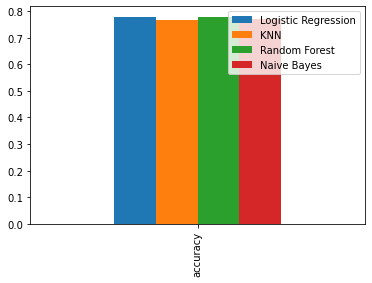

In [100]:
models_compare = pd.DataFrame(model_scores, index=["accuracy"])
models_compare.plot.bar()

In [ ]:
# Let's tune KNN

train_scores = []
test_scores = []

# Create a list of different values for n_neighbours
neighbors = range(10,30)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neughbors
for i in neighbors: # default = 5
    knn.set_params(n_neighbors=i)
    
    # Fit the algorithm
    knn.fit(x_train, y_train)
    
    # Update the training scores list
    train_scores.append(knn.score(x_train, y_train))
    
    # Update the test scores list
    test_scores.append(knn.score(x_test, y_test))
    
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores,label="Test score")
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()
plt.xticks(np.arange(10, 30, 1))
print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

In [ ]:
# For LogiscticRegression model
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                #"classifier__penalty" : ['l1', 'l2'],
               "solver": ["liblinear"]} #return log scale

# Setup grid
gs_log_reg = GridSearchCV(LogisticRegression(),
                         param_grid=log_reg_grid,
                         cv=5,
                         verbose=True)
# Fit grid search
gs_log_reg.fit(x_train, y_train)

In [ ]:
gs_log_reg.best_params_

In [ ]:
gs_log_reg.score(x_test, y_test)

## CV

In [125]:
from catboost import CatBoostClassifier

N_SPLITS = 5 # 10 is better but memory allocated
N_ESTIMATORS = 3000 # 300, 500 1000 is better but It will take a little longer.and memory problems.
RANDOM_STATE = 42 # tried 1,42 

params = {
   'n_estimators' : N_ESTIMATORS,
    'n_jobs' : -1,
     'random_state' : RANDOM_STATE
}

#train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)

scores_2 = []
scores_3 = []

y_probs_2 = []
y_probs_3 = []

folds = StratifiedKFold(n_splits = N_SPLITS, shuffle=True)

for fold, (train_id, test_id) in enumerate(folds.split(X, y)):  
    
    print("fold : ", fold + 1, end = ' ')
  
    X_train = X.iloc[train_id]
    y_train = y.iloc[train_id]
    X_valid = X.iloc[test_id]
    y_valid = y.iloc[test_id]
    
    # model_2
    #Best: depth-10, learning_rate-0.1
    #model_2 =  ExtraTreesClassifier(**params)
    #model_2 =  RandomForestClassifier(**params)
    #model_2 =  CatBoostClassifier(verbose=False, depth=10, learning_rate=0.1)
    model_2 =  CatBoostClassifier(verbose=False)
    #model_2 = LogisticRegression(C = 0.012742749857031334)
    
    model_2.fit(X_train, y_train)
    # validation
    valid_pred_2 = model_2.predict(X_valid)
    valid_score_2 = accuracy_score(y_valid, valid_pred_2)
    #print( "model_2 :: Accuracy_score: ", valid_score_2, end = ' ')
    print( "Validation score: ", valid_score_2, end = ' ')
    scores_2.append(valid_score_2)
    
    # test
    y_pred_2 = model_2.predict(test)
    y_probs_2.append(model_2.predict_proba(test))
    print("")
    
    # model_3
  
#     model_3 = BaggingClassifier(model_2,  random_state = RANDOM_STATE)
#     model_3.fit(X_train, y_train)
#     valid_pred_3 = model_3.predict(X_valid)
#     valid_score_3 = accuracy_score(y_valid, valid_pred_3)
#     print( "model_3 :: Accuracy_score: ", valid_score_3)
#     scores_3.append(valid_score_3)
    
#     # test
#     y_pred_3 = model_3.predict(test)
#     y_probs_3.append(model_3.predict_proba(test))

fold :  1 Validation score:  0.78953421506613 
fold :  2 Validation score:  0.80448533640023 
fold :  3 Validation score:  0.8062104657849338 
fold :  4 Validation score:  0.8032220943613348 
fold :  5 Validation score:  0.8095512082853855 


In [126]:
# 0.78
import statistics
statistics.mean(scores_2)

0.8026006639796028

# Submission

In [115]:
# model = CatBoostClassifier()
# model.fit(train, y)
# preds = model.predict(test)

# preds_n = []
# for i in preds:
#     if i == 0:
#         preds_n.append(False)
#     else:
#         preds_n.append(True)


In [127]:
sub.head(2)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False


In [128]:
y_prob_3 = sum(y_probs_2) / len(y_probs_2)
y_prob_3

preds = []
for i in y_prob_3:
    if i[0] > i[1]:
        preds.append(False)
    else:
        preds.append(True)
        
def save_submission(y_pred):  
    #classes = label.inverse_transform(y_pred)
    sub["Transported"] = y_pred
    #assert len(classes) == sub.shape[0]
    assert 2 == sub.shape[1]   
    sub.to_csv("/home/mikhail/Downloads/sample_submission.csv'", index=False)
    return sub
save_submission(preds).head(3)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
